# Treinando uma rede neural como controlador do Cooler

Nesta atividade de programação, você irá treinar uma rede neural capaz de controlar a velocidade de um cooler.

In [1]:
# Carregando os pacotes e bibliotecas que serão usadas nessa atividade:

import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

## Carregando a rede neural que modela o comportamento do Cooler

Abaixo nós carregamos a rede neural que representa o modelo que estima o comportamento do cooler. Abaixo, substitua o nome "modelo_cooler_v240210_4_4.h5" pelo modelo que você obteve na parte 1 deste experimento.

In [2]:
# Importante: observou-se que é difícil treinar um controlador caso os dados não estejam normalizados desde sua origem.

n      = 3 # número de características
modelo = Sequential(
    [
        tf.keras.Input(shape=(n,)),    # especificando a dimensão do vetor de entrada (não é obrigatório especificar)
        #Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)), # note o termo de regularização aqui
        #Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)), # note o termo de regularização aqui
        Dense(4, activation="relu"),
        Dense(4, activation="relu"),
        Dense(1, activation="linear") # Essa forma aqui é mais robusta contra erros de arredondamento, entretanto, quando usamos linear aqui precisamos usar BinaryCrossentropy(from_logits=True)
    ], name = "modelo_cooler"   # Na definição do nome do modelo, não pode haver espaços em branco
)

#modelo.load_weights("modelo_cooler_v240131_128_128.h5")
modelo.load_weights("modelo_cooler_v240210_4_4.h5")
modelo.summary()

Model: "modelo_cooler"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 16        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 41 (164.00 Byte)
Trainable params: 41 (164.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Criando um ambiente de simulação para o Cooler

Agora nós iremos utilizar a rede neural que acabamos de carregar para criar um ambiente de simulação para o Cooler.

Esse ambiente de simulação permite testar exaustivamente como o Cooler se comporta frente a diferentes condições operativas, partindo de diferentes velocidades iniciais e buscando seguir diferentes valores de referência de velocidade. Assim, esse ambiente de simulação também permitirá que uma segunda rede neural seja projetada, usando uma abordagem baseada em aprendizado por reforço. Essa segunda rede neural operará como controlador do Cooler.

In [41]:
class Ambiente_Cooler:
    def __init__(self, modelo):
        self.num_acoes   = 1      # razão cíclica para pwm arduino uno
        self.max_speed   = 5.0    # equivale à 6000 rpm (usei média 3500 e desvio padrão 500)
        self.min_speed   = -4.0   # equivale à 1500 rpm (usei média 3500 e desvio padrão 500)
        self.max_pwm     = 1.0    # equivale à 255 (usei u_max = 255 e u_min = 55 na equação u_novo  = 2*(u-u_min)/(u_max-u_min) - 1)
        self.min_pwm     = -1.0   # equivale à 55 (usei u_max = 255 e u_min = 55 na equação u_novo  = 2*(u-u_min)/(u_max-u_min) - 1)
        self.modelo      = modelo
        self.dt          = 0.05   # período de amostragem (passo de tempo)
        self.reset()

    def step(self, acao):
        # captura o estado atual a partir do self:
        estado_atual   = self.estado_atual
        rpm_ref_atual  = self.rpm_ref_atual
        rpm_atual      = self.rpm_atual
        rpm_dot_atual  = self.rpm_dot_atual
        erro_atual     = self.erro_atual
        int_erro_atual = self.int_erro_atual

        # agora iremos aplicar a ação com base no estado atual para que seja possível obter o novo estado
        acao          = np.clip(acao, self.min_pwm, self.max_pwm)
        modelo        = self.modelo
        x             = np.array([rpm_atual, rpm_dot_atual, acao]).reshape((1,-1)) # entrada do modelo da planta
        novo_rpm      = modelo(x)
        novo_rpm      = np.clip(novo_rpm, -self.max_speed, self.max_speed)[0]

        # definição do novo estado (próximo estado):
        rpm_ref_novo   = rpm_ref_atual
        rpm_novo       = novo_rpm
        rpm_dot_novo   = rpm_novo - rpm_atual
        erro_novo      = rpm_ref_novo - rpm_novo
        int_erro_novo  = int_erro_atual + erro_novo

        #estado_novo     = np.array([rpm_novo, rpm_dot_novo, erro_novo]).reshape((-1,))
        #estado_novo     = np.array([rpm_ref_novo, rpm_dot_novo, erro_novo]).reshape((-1,))
        estado_novo   = np.array([rpm_novo, rpm_dot_novo, erro_novo, int_erro_novo]).reshape((-1,))

        # atualiza o estado atual como sendo o novo estado:
        self.estado_atual   = estado_novo
        self.rpm_ref_atual  = rpm_ref_novo
        self.rpm_atual      = rpm_novo
        self.rpm_dot_atual  = rpm_dot_novo
        self.erro_atual     = erro_novo
        self.int_erro_atual = int_erro_novo

        if (self.time_step_k == 100): # episódio termina após X passos de tempo (isso define o tamanho de cada episódio)
            self.flag_estado_terminal = True
        else:
            self.flag_estado_terminal = False
        self.time_step_k = self.time_step_k + 1

        # cálculo da recompensa (os pesos abaixo foram definidos buscando-se fazer que os termos de recompensa tenham ordens de grandeza parecidas)
        alpha           = 5.0
        #beta            = 0.0
        beta            = 30.000
        #gamma           = 0.001
        gamma           = 0.000
        self.recomp1    = -alpha*(erro_novo**2)
        self.recomp2    = -beta*(rpm_dot_novo**2)
        self.recomp3    = -gamma*(int_erro_novo**2)
        #self.recomp1    = -alpha*(erro_atual**2)
        #self.recomp2    = -beta*(rpm_dot_atual**2)
        self.recompensa = self.recomp1 + self.recomp2 + self.recomp3

    def reset(self):
        # define o estado inicial
        rpm_ref_atual       = np.array([np.random.uniform(low=-3, high=2)]) # em rpm, equivale à low=2000, high=4500
        rpm_atual           = np.array([np.random.uniform(low=-3, high=2)]) # em rpm, equivale à low=2000, high=4500
        rpm_ant             = rpm_atual
        rpm_dot_atual       = rpm_atual - rpm_ant
        erro_atual          = rpm_ref_atual - rpm_atual
        int_erro_atual      = erro_atual

        #estado_inicial      = np.array([rpm_atual, rpm_dot_atual, erro_atual]).reshape((-1,))
        #estado_inicial      = np.array([rpm_ref_atual, rpm_dot_atual, erro_atual]).reshape((-1,))
        estado_inicial      = np.array([rpm_atual, rpm_dot_atual, erro_atual, int_erro_atual]).reshape((-1,))

        estado_atual        = estado_inicial

        # armazenando o estado inicial no self:
        self.estado_inicial = estado_inicial
        self.estado_atual   = estado_atual
        self.rpm_ref_atual  = rpm_ref_atual
        self.rpm_atual      = rpm_atual
        self.rpm_dot_atual  = rpm_dot_atual
        self.erro_atual     = erro_atual
        self.int_erro_atual = int_erro_atual

        # armazena mais algumas informações importantes no self:
        self.time_step_k          = 0       # passo de tempo atual
        self.flag_estado_terminal = False   # define o estado inicial como não sendo um estado terminal (estado onde a simulação do episódio deve ser encerrada)

Abaixo é mostrado como nós fazemos para inicializar o ambiente do Cooler

In [42]:
cooler = Ambiente_Cooler(modelo=modelo) # Cria o objeto referente ao Cooler

cooler.reset() # reinicializa o ambiente, colocando o cooler numa velocidade inicial aleatória entre 2000 e 4500 rpm
print(f'Velocidade inicial do Cooler: {500*cooler.rpm_atual+3500}')

Velocidade inicial do Cooler: [4485.74724045]


Abaixo é mostrado como podemos aplicar um valor de razão cíclica de pwm de 255 no Cooler e então verificar a sua nova velocidade (ou seja, a velocidade associada ao instante seguinte de tempo - ou seja, após Ts segundos):


In [43]:
acao = np.array((1.0000,)) # é equivalente ao pwm 255 do arduino uno. OBS: rode essa célula várias vezes para verificar a velocidade do Cooler aumentando ao longo do tempo.
cooler.step(acao) # pratica a ação de controle definida pela variável `acao`
print(f'Velocidade atual do Cooler: {500*cooler.rpm_atual+3500}')

Velocidade atual do Cooler: [4535.7373]


Como um exercício de verificação, abaixo nós iremos aplicar um degrau na entrada do sistema buscando repetir o processo que foi feito quando da sua identificação (modelagem). A ideia é que os mesmos resultados sejam observados. Nesse sentido, estaremos definindo uma velocidade inicial de -3 unidades (ou seja, 2000 rpm).

Rodando a célula abaixo, você irá perceber que o Ambiente Cooler também é sempre inicializado com uma velocidade de referência desejada aleatória entre 2000 e 4500 rpm. O sinal de erro também é calculado, assim como a recompensa obtida como resultado da velocidade do Cooler seguir ou não esse valor de referência. Essa ideia de recompensa é algo muito forte no contexto de Aprendizado por Reforço.

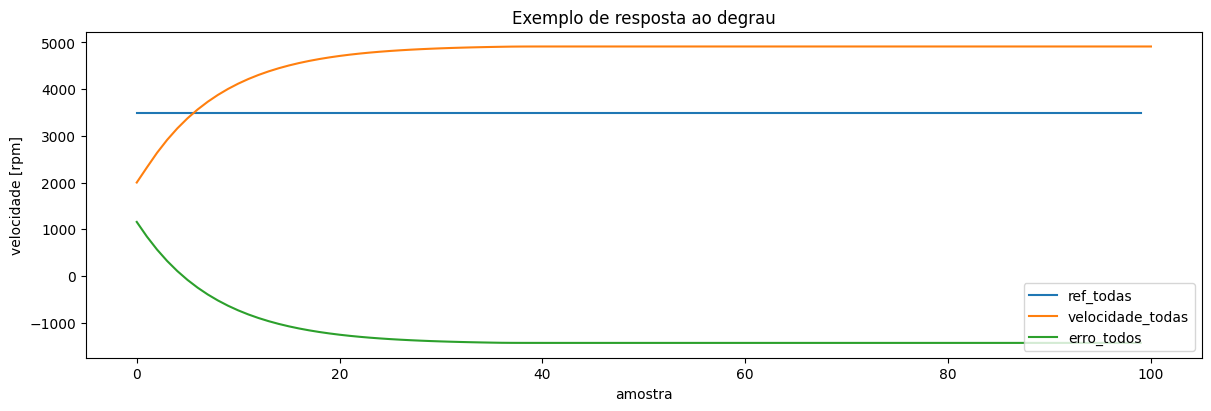

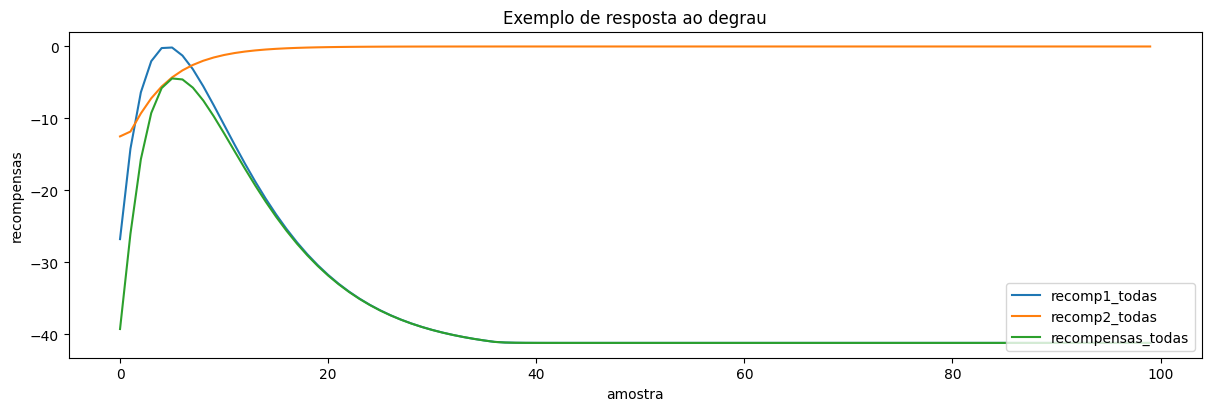

v(Inf) para pwm=255: 4914.12 rpm


In [44]:
# Testando a classe cooler

cooler = Ambiente_Cooler(modelo=modelo) # Cria o objeto referente ao Cooler

cooler.reset() # reinicializa o ambiente, colocando o cooler numa velocidade inicial aleatória entre 2000 e 4500 rpm

cooler.rpm_atual = np.array((-3,)) # força que a velocidade inicial seja -3 (ou seja, 2000 rpm). O objetivo é repetir o degrau aplicado quando da identificação (modelagem) do Cooler

ref_todas            = []
velocidade_todas     = []
erro_todos           = []
recomp1_todas        = []
recomp2_todas        = []
recomp3_todas        = []
recompensas_todas    = []

acao                 = np.array((1.0000,)) # é equivalente ao pwm 255 do arduino uno

velocidade_todas.append(cooler.rpm_atual) # armazena velocidade inicial na lista criada

for t in range(100):
    cooler.step(acao) # pratica a ação de controle definida pela variável `acao`

    ref_todas.append(cooler.rpm_ref_atual)
    velocidade_todas.append(cooler.rpm_atual)
    erro_todos.append(cooler.erro_atual)
    recomp1_todas.append(cooler.recomp1)
    recomp2_todas.append(cooler.recomp2)
    recomp3_todas.append(cooler.recomp3)
    recompensas_todas.append(cooler.recompensa)

ref_todas            = np.array(ref_todas)
velocidade_todas     = np.array(velocidade_todas)
erro_todos           = np.array(erro_todos)
recomp1_todas        = np.array(recomp1_todas)
recomp2_todas        = np.array(recomp2_todas)
recomp3_todas        = np.array(recomp3_todas)
recompensas_todas    = np.array(recompensas_todas)

# Plotando os resultados do degrau
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(500*ref_todas+3500, label='ref_todas')
ax.plot(500*velocidade_todas+3500, label='velocidade_todas')
ax.plot(500*erro_todos, label='erro_todos')
ax.set_title("Exemplo de resposta ao degrau")
ax.legend(loc='lower right')
ax.set_ylabel('velocidade [rpm]')
ax.set_xlabel('amostra')
plt.show()

# Plotando os resultados das recompensas (este gráfico foi usado para definir os pesos alpha e beta)
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(recomp1_todas, label='recomp1_todas')
ax.plot(recomp2_todas, label='recomp2_todas')
#ax.plot(recomp3_todas, label='recomp3_todas')
ax.plot(recompensas_todas, label='recompensas_todas')
ax.set_title("Exemplo de resposta ao degrau")
ax.legend(loc='lower right')
ax.set_ylabel('recompensas')
ax.set_xlabel('amostra')
plt.show()

print(f'v(Inf) para pwm=255: {500*velocidade_todas[-1,0]+3500:.2f} rpm')

Abaixo fazemos o mesmo teste só que agora consideraremos um degrau no pwm de -1 (que significa 55)

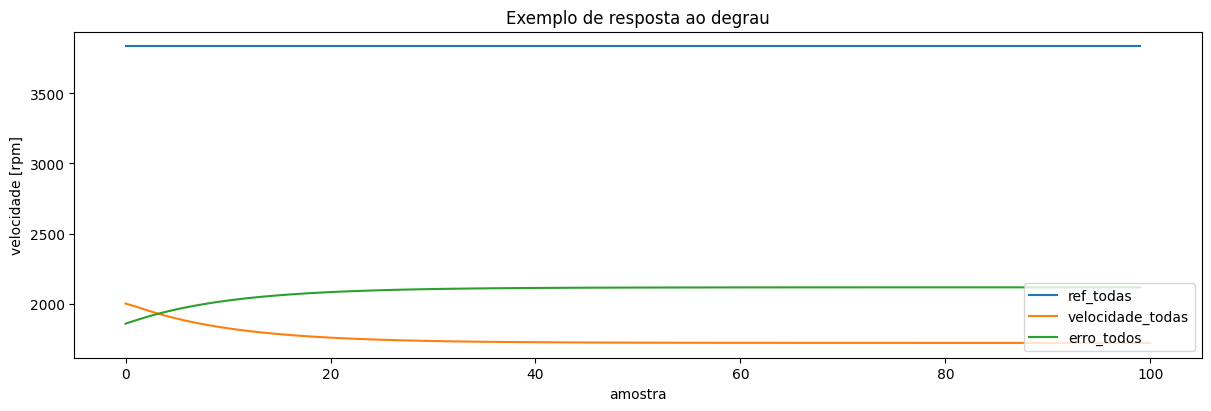

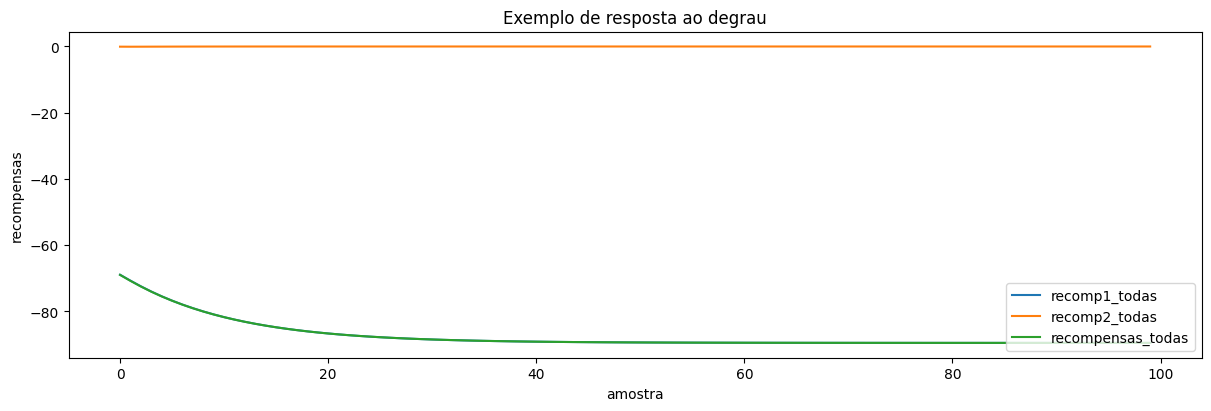

v(Inf) para pwm=55: 1719.16 rpm


In [45]:
# Testando a classe cooler

cooler = Ambiente_Cooler(modelo=modelo) # Cria o objeto referente ao Cooler

cooler.reset() # reinicializa o ambiente, colocando o cooler numa velocidade inicial aleatória entre 2000 e 4500 rpm

cooler.rpm_atual = np.array((-3,)) # força que a velocidade inicial seja -3 (ou seja, 2000 rpm). O objetivo é repetir o degrau aplicado quando da identificação (modelagem) do Cooler

ref_todas            = []
velocidade_todas     = []
erro_todos           = []
recomp1_todas        = []
recomp2_todas        = []
recomp3_todas        = []
recompensas_todas    = []

acao                 = np.array((-1.0000,)) # é equivalente ao pwm 55 do arduino uno

velocidade_todas.append(cooler.rpm_atual) # armazena velocidade inicial na lista criada

for t in range(100):
    cooler.step(acao) # pratica a ação de controle definida pela variável `acao`

    ref_todas.append(cooler.rpm_ref_atual)
    velocidade_todas.append(cooler.rpm_atual)
    erro_todos.append(cooler.erro_atual)
    recomp1_todas.append(cooler.recomp1)
    recomp2_todas.append(cooler.recomp2)
    recomp3_todas.append(cooler.recomp3)
    recompensas_todas.append(cooler.recompensa)

ref_todas            = np.array(ref_todas)
velocidade_todas     = np.array(velocidade_todas)
erro_todos           = np.array(erro_todos)
recomp1_todas        = np.array(recomp1_todas)
recomp2_todas        = np.array(recomp2_todas)
recomp3_todas        = np.array(recomp3_todas)
recompensas_todas    = np.array(recompensas_todas)

# Plotando os resultados do degrau
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(500*ref_todas+3500, label='ref_todas')
ax.plot(500*velocidade_todas+3500, label='velocidade_todas')
ax.plot(500*erro_todos, label='erro_todos')
ax.set_title("Exemplo de resposta ao degrau")
ax.legend(loc='lower right')
ax.set_ylabel('velocidade [rpm]')
ax.set_xlabel('amostra')
plt.show()

# Plotando os resultados das recompensas (este gráfico foi usado para definir os pesos alpha e beta)
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(recomp1_todas, label='recomp1_todas')
ax.plot(recomp2_todas, label='recomp2_todas')
#ax.plot(recomp3_todas, label='recomp3_todas')
ax.plot(recompensas_todas, label='recompensas_todas')
ax.set_title("Exemplo de resposta ao degrau")
ax.legend(loc='lower right')
ax.set_ylabel('recompensas')
ax.set_xlabel('amostra')
plt.show()

print(f'v(Inf) para pwm=55: {500*velocidade_todas[-1,0]+3500:.2f} rpm')

Abaixo é realizada uma rápida checagem que busca verificar qual é o tamanho de cada episódio de simulação. Após esse tamanho ser ultrapassado, a variável `cooler.flag_estado_terminal` passa a ser `True`. Usaremos essa variável como uma variável auxiliar que permitirá resetar o ambiente do cooler e iniciar um novo episódio de simulação

In [46]:
# apenas checando:
print(cooler.time_step_k)
print(cooler.flag_estado_terminal)

# mais uma checagem:
cooler.step(acao)
print(cooler.time_step_k)
print(cooler.flag_estado_terminal)

# mais uma checagem:
cooler.reset()
print(cooler.time_step_k)
print(cooler.flag_estado_terminal)

100
False
101
True
0
False


Na célula abaixo, mostramos o número de estados usados como entrada do controlador e também a dimensão da sua saída (no nosso caso, essa dimensão de saída é unitária e corresponde ao valor de razão cíclica do pwm).

Também é mostrado que os valores limites de razão cíclica do pwm: -1 e +1. Cumpre destacar que trata-se da escala normalizada, onde -1 significa 55 e +1 significa 255.

In [9]:
limite_superior = cooler.max_pwm
limite_inferior = cooler.min_pwm

num_estados     = cooler.estado_inicial.shape[0]
num_acoes       = cooler.num_acoes

print('Número de estados:', num_estados)
print('Número de ações possíveis:', num_acoes)

print("Maior valor possível para a ação ->  {}".format(limite_superior))
print("Menos valor possível para a ação ->  {}".format(limite_inferior))

Número de estados: 4
Número de ações possíveis: 1
Maior valor possível para a ação ->  1.0
Menos valor possível para a ação ->  -1.0


Abaixo mostramos ainda mais uma maneira de interagirmos com o ambiente de simulação do Cooler.

## Desafio

Rodando a célula abaixo repetidamente, busque fazer com que a velocidade do Cooler atinja o valor de referência. Faça isso variando o valor da variável `acao` com o objetivo de zerar o erro em regime permanente. Ou seja, aqui você cumprirá o papel de **controlador**, e escolherá a ação que você julga ser a mais adequada para cada instante de tempo.

In [73]:
# Selecione uma ação com o objetivo de zerar o erro (erro entre referência e velocidade atual)
acao = 0.0 # escolher um valor de ação entre -1 e +1 (pois corresponde a valores de razão cíclica de PWM de 55 a 255)
estado_atual = cooler.estado_atual

# praticando a ação
cooler.step(np.array((acao,))) # pratica a ação de controle definida pela variável `acao`
proximo_estado = cooler.estado_atual
recompensa     = cooler.recompensa
done           = cooler.flag_estado_terminal
erro           = cooler.erro_atual
with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Estado atual:", estado_atual)
    print("Ação:", acao)
    print("Próximo Estado:", proximo_estado)
    print("Recompensa Recebida:", recompensa)
    print("Fim do Episódio?:", done)
    print("Velocidade de referência em rpm:", 500*cooler.rpm_ref_atual+3500)
    print("Velocidade atual do Cooler em rpm:", 500*cooler.rpm_atual+3500)


Estado atual: [0.671 0.027 -1.851 -22.811]
Ação: 0.0
Próximo Estado: [0.695 0.024 -1.875 -24.686]
Recompensa Recebida: [-17.599]
Fim do Episódio?: False
Velocidade de referência em rpm: [2909.921]
Velocidade atual do Cooler em rpm: [3847.525]


## Criando o Ator inicial e o Crítico inicial

No contexto de Aprendizado por Reforço, o controlador é também chamado de **ator**. Na célula abaixo, nós criamos esse ator para que ele tenha uma estrutura do tipo

`PWM_norm = tanh(RPM_norm*0.14161868 + rpm_dot_norm*-0.51625645 + erro_norm*0.7853998 + int_erro_norm*0.00947142 - 0.25869885)`

Note que a inicialização para a última camada do ator (controlador) é feita com valores entre -0.003 e 0.003. Isso previne que a gente obtenha valores de saída próximos dos limites +1 e -1 no início do treinamento, o que levaria nossos gradientes à zero, uma vez que estamos usando a tangente hiperbólica como função de ativação.

Além do ator (controlador), abaixo também é definida uma rede neural que opera como **crítico**. O objetivo desse crítico é aprender qual sequência de ações de controle provê a maior recompensa possível.

In [11]:
def cria_ator():
    # Inicializa os pesos W e B da última camada do ator entre -3e-3 e 3-e3: Estamos selecionando pesos iniciais pequenos para evitar que ações sejam +-1, o que levaria os nossos gradientes à zero.
    inicializacao_ultima_camada = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs  = layers.Input(shape=(num_estados,))
#    out     = layers.Dense(1, activation="relu")(inputs)
#    out     = layers.Dense(1, activation="relu")(out)
#    outputs = layers.Dense(1, activation="tanh", kernel_initializer=inicializacao_ultima_camada)(out) # Lembrar que tangente hiperbólica é semelhante à sigmoide, mas retorna valores entre -1 e +1, ao invés de 0 e +1.
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=inicializacao_ultima_camada)(inputs) # Lembrar que tangente hiperbólica é semelhante à sigmoide, mas retorna valores entre -1 e +1, ao invés de 0 e +1.

#    # Supondo que os estados são [rpm_atual, rpm_dot, erro, int_erro]
#    inputs  = layers.Input(shape=(num_estados,)) # conterá [rpm_atual, rpm_dot, erro, int_erro]
#    output1 = inputs[:,:3] # conterá [rpm_atual, rpm_dot, erro]
#    output2 = layers.Dense(1, activation="tanh")(inputs[:,3:4]) # conterá o [int_erro], que será passado por uma tangente hiperbólica.
#    concat  = tf.concat([output1, output2], axis=-1)
#    #concat = tf.concat([inputs[:, :2], layers.Dense(1, activation="tanh")(inputs[:,2:3]), inputs[:, 3:]], axis=-1)
#
#    outputs = layers.Dense(1, activation="tanh", kernel_initializer=inicializacao_ultima_camada)(concat)
#
#    #outputs = layers.Dense(2, activation="tanh")(concat) # Lembrar que tangente hiperbólica é semelhante à sigmoide, mas retorna valores entre -1 e +1
#    #outputs = layers.Dense(1, activation="tanh", kernel_initializer=inicializacao_ultima_camada)(outputs)

    model   = tf.keras.Model(inputs, outputs)

    return model


def cria_critico():
    # Definição do estado como entrada
    state_input = layers.Input(shape=(num_estados))
    state_out = layers.Dense(4, activation="relu")(state_input)
    state_out = layers.Dense(8, activation="relu")(state_out)

    # Definição da ação como entrada
    action_input = layers.Input(shape=(num_acoes))
    action_out = layers.Dense(8, activation="relu")(action_input)

    # Tanto o estado como a ação são passados por camadas separadas antes de serem concatenados
    concat = layers.Concatenate()([state_out, action_out])

    out     = layers.Dense(64, activation="relu")(concat)
    out     = layers.Dense(64, activation="relu")(out)
    outputs = layers.Dense(1)(out) # Lembrar que a ativação default é: "Linear". Ou seja, sem ativação.

    # Calcula o Retorno Q(s,a) resultante para um dado par estado-ação
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

Abaixo nos criamos um exemplo de Ator (controlador) inicial (com pesos aleatórios)

In [12]:
modelo_ator = cria_ator()

modelo_ator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 5 (20.00 Byte)
Trainable params: 5 (20.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
modelo_ator.get_weights()

[array([[-0.00157476],
        [ 0.00261832],
        [-0.00111485],
        [-0.00121386]], dtype=float32),
 array([0.], dtype=float32)]

In [75]:
# abaixo nós testamos o ator para o estado inicial

estado = cooler.estado_inicial.reshape(1,-1)

print("Valor de PWM normalizado fornecido pelo controlador: ", modelo_ator(estado) )

Valor de PWM normalizado fornecido pelo controlador:  tf.Tensor([[0.39434877]], shape=(1, 1), dtype=float32)


## Verificando como se comporta o Ator inicial (antes de receber treinamento)

Iremos verificar agora como o Ator (controlador) controla o cooler inicialmente, antes de receber qualquer tipo de treinamento.

<ipython-input-76-a55b1169924c>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rpm_todos[t]   = cooler.rpm_atual
<ipython-input-76-a55b1169924c>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  acoes_todas[t] = acao
<ipython-input-76-a55b1169924c>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ref_todas[t]   = cooler.rpm_ref_atual


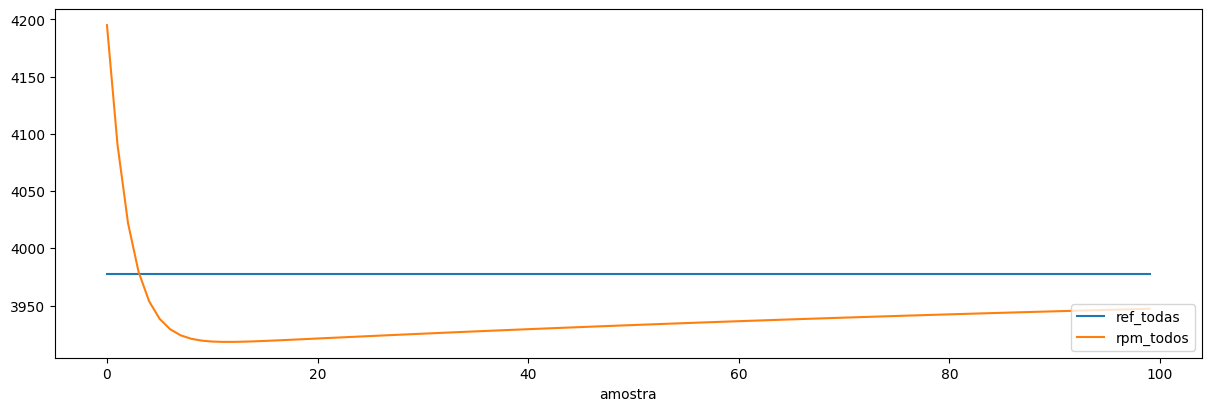

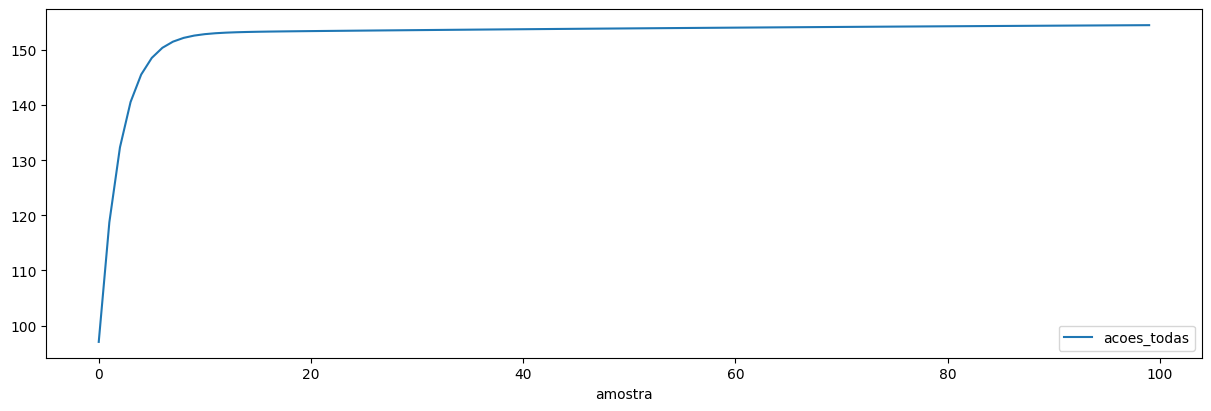

In [76]:
cooler.reset() # reinicializa o ambiente, colocando o cooler numa velocidade inicial aleatória entre 2000 e 4500 rpm
estado_atual = cooler.estado_inicial
estado_atual = estado_atual.reshape((1,-1))

acoes_todas    = np.zeros(100)
rpm_todos      = np.zeros(100)
ref_todas      = np.zeros(100)
num_amostras   = acoes_todas.shape[0]

for t in range(num_amostras):
    #print(estado_atual.shape)
    acao = modelo_ator(estado_atual).numpy()[0] # define a ação a ser praticada com base no ator
    cooler.step(acao) # pratica a ação
    rpm_todos[t]   = cooler.rpm_atual
    estado_atual   = cooler.estado_atual.reshape((1,-1)) # atualiza o estado atual
    acoes_todas[t] = acao
    ref_todas[t]   = cooler.rpm_ref_atual

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(500*ref_todas+3500, label='ref_todas')
ax.plot(500*rpm_todos+3500, label='rpm_todos')
ax.legend(loc='lower right')
ax.set_xlabel('amostra')
plt.show()

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot((acoes_todas+1)*(255-55)/2 + 55, label='acoes_todas')
ax.legend(loc='lower right')
ax.set_xlabel('amostra')
plt.show()


## Possibilitando Exploração por parte do Ator

Para implementar uma melhor exploração de novidades (em termos de ações) pelo Ator durante o treinamento, usaremos perturbações aleatórias. Ou seja, supondo que estamos num estado $s_t$, sempre que o ator sugerir que devemos praticar uma ação $\mu(s_t)$, praticaremos, na verdade

$$
a_t = \mu(s_t) + \mathcal{N}_t
$$

onde $\mathcal{N}_t$ denota um pequeno ruído gerado aleatoriamente, e que visa fazer com que o Ator explore novidades.

Especificamente, nesse caso de ações contínuas, usaremos o chamado Processo de Ornstein-Uhlenbeck para gerar um ruído correlacionado. Isso é feito amostrando-se uma distribuição normal que correlaciona o ruído gerado agora com o ruído gerado anteriormente.

Tendo como base o que está em https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process, para simularmos um processo de Ornstein-Uhlenbeck numericamente, iremos aplicar recursivamente a fórmula

$$
  x_t = x_{t-1} + \theta(\mu - x_{t-1})dt  + \sigma ~ \nu_t \sqrt{ dt }  
$$

onde

* $\mu$ é a média (nós usaremos $\mu=0$)
* $\sigma$ é o desvio padrão (nós usaremos $\sigma=0.2$)
* $\theta$ é o tempo de correlação (nós usaremos $\theta=0.15$)
* $dt$ é o passo de tempo, ou seja, período de amostragem (nós usaremos $dt=0.01$)
* $\nu_t$ é um número aleatório normalmente distribuído com média 0 e variância unitária (usaremos a função `np.random.normal` para gerar esse valor)
* Nós inicializaremos $x_{t-1}$ como sendo 0.

Segue abaixo o código que cria uma classe para gerarmos o ruído em questão.

In [17]:
class acao_ruidosa_Ornstein_Uhlenbeck:
    def __init__(self, mean, std_deviation, theta=0.15, dt=0.05, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Fórmula extraída do link https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_ant
            + self.theta * (self.mean - self.x_ant) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Armazena x na varável x_ant
        # Faz com que o próximo ruído (ou seja, a próxima ação) seja dependente do ruído atual:
        self.x_ant = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_ant = self.x_initial
        else:
            self.x_ant = np.zeros_like(self.mean)

Apenas para exemplificar, abaixo nós geramos um ruído de Ornstein-Uhlenbeck (considerando 200 amostras) e plotamos o resultado. Como $\nu_t$ é um número gerado aleatoriamente, é esperado um ruído diferente para cada vez que a célula abaixo é rodada.

Também note que o ruído é de fato correlacionado.

<ipython-input-77-4a03d28fe5ce>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ruido_todos[i]        = ruido_t


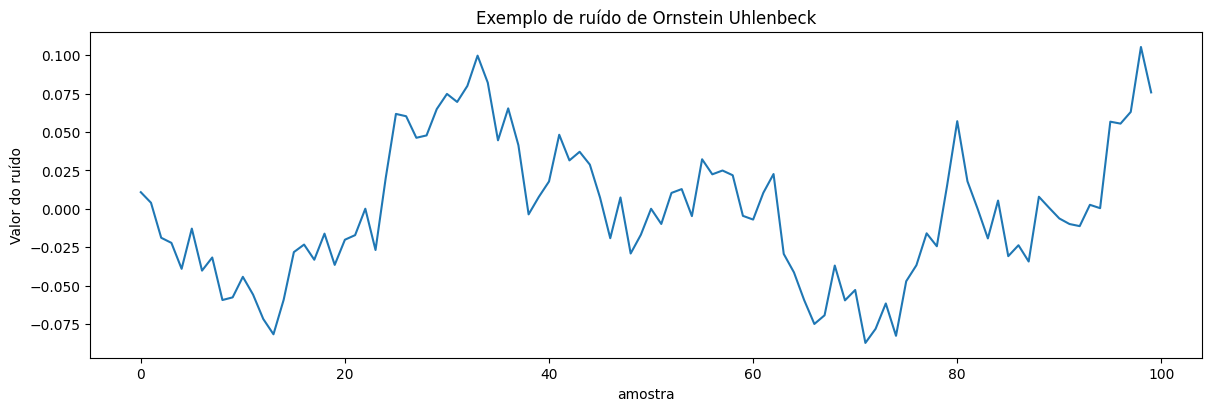

In [77]:
desvio_padrao   = 0.1
objeto_ruido_OU = acao_ruidosa_Ornstein_Uhlenbeck(mean=np.zeros(1), std_deviation=float(desvio_padrao) * np.ones(1)) # Cria o objeto referente ao Ruído de Ornstein-Uhlenbeck (OU)

ruido_todos  = np.zeros(100)
num_amostras = ruido_todos.shape[0]
for i in range(num_amostras):
    amplificador_do_ruido = 1.0
    ruido_t               = amplificador_do_ruido * objeto_ruido_OU()
    ruido_todos[i]        = ruido_t

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(ruido_todos)
ax.set_title("Exemplo de ruído de Ornstein Uhlenbeck")
ax.set_ylabel('Valor do ruído')
ax.set_xlabel('amostra')
plt.show()

Agora que já temos o nosso gerador de ruído de exploração, estamos prontos para implementar uma função que calcula a ação que será usada durante a etapa de treinamento, qual seja:

$$
a_t = \mu(s_t) + \mathcal{N}_t
$$

Ou seja, a nossa política consiste em usar a saída do nosso Ator adicionada a um pequeno ruído que visa exploração.

In [19]:
def politica(estado, objeto_ruido_OU):
    acao_t                = tf.squeeze(modelo_ator(estado))
    amplificador_do_ruido = 1.0
    ruido_t               = amplificador_do_ruido * objeto_ruido_OU()
    acao_t                = acao_t.numpy() + ruido_t   # adicionando ruido à ação

    # Garante que a ação estará dentro dos limites inferior e superior
    acao_t_legal = np.clip(acao_t, limite_inferior, limite_superior)

    return [np.squeeze(acao_t_legal)]

## Implementação do Buffer de Experiência

Quando um agente interage com o ambiente, os estados, ações e recompensas são sequenciais por natureza. Se um agente tenta aprender a partir dessas experiências consecutivas ele pode encontrar problemas devido às fortes correlações entre elas. Para evitar isso, nós usamos uma técnica chamada de **Replay de Experiência** para gerar experiências descorrelacionadas que serão usadas para treinar o nosso agente. Replay de experiência consiste em armazenar as experiências do agente (isto é, estados, ações e recompensas obtidas pelo agente) em um **Buffer de Memória** (também chamado de Buffer de Replay) e então amostrar um mini-lote aleatório de experiência do buffer para realizar o aprendizado. As tuplas de experiência $(s, a, R(s), s')$ serão adicionadas ao Buffer de Memória a cada passo de tempo à medida com que o agente interage com o ambiente.

Usando o conceito de Replay de Experiência nós evitamos correlações problemáticas e instabilidades. Além disso, esse conceito permite que o agente potencialmente use a mesma experiência em múltiplas atualizações dos pesos, o que aumenta a eficiência dos dados.

In [20]:
class Buffer:
    def __init__(self, buffer_capacidade=100000, minilote_tamanho=64): # inicialização do Buffer.
        # Capacidade máxima de armazenamento de tuplas de experiência no Buffer de Replay
        self.buffer_capacidade = buffer_capacidade
        # Número de tuplas usadas durante 1 passo de treinamento.
        self.minilote_tamanho = minilote_tamanho

        # A variável buffer_contador conta a quantidade de vezes que já chamamos a função armazenar_tupla().
        self.buffer_contador = 0

        # Usaremos aqui np.arrays diferentes para cada elemento da tupla
        self.buffer_estado         = np.zeros((self.buffer_capacidade, num_estados))
        self.buffer_acao           = np.zeros((self.buffer_capacidade, num_acoes))
        self.buffer_recompensa     = np.zeros((self.buffer_capacidade, 1))
        self.buffer_proximo_estado = np.zeros((self.buffer_capacidade, num_estados))

    def armazenar_tupla(self, tupla_observada): # função que armazena no Buffer a tupla que acabou de ser observada.
        indice = self.buffer_contador % self.buffer_capacidade # A operaçãp A % B mostra o resto da divisão B/A. Servirá para substituirmos tuplas antigas quando o Buffer já estiver cheio

        self.buffer_estado[indice]         = tupla_observada[0]
        self.buffer_acao[indice]           = tupla_observada[1]
        self.buffer_recompensa[indice]     = tupla_observada[2]
        self.buffer_proximo_estado[indice] = tupla_observada[3]

        self.buffer_contador += 1

    # Para aumentar a performance computacional, iremos usar a função `@tf.function`. Se não usarmos isso, o treinamento levará o dobro do tempo +-, conforme detalhado na [Documentação do Tensorflow](https://www.tensorflow.org/guide/function).
    # A função @tf.function permite que o TensorFlow crie uma lógica que acelerá a execução de blocos de código que contém diversas operações Tensorflow, como é o caso da função abaixo.
    @tf.function
    def atualiza_modelos(
        self, minilote_estado, minilote_acao, minilote_recompensa, minilote_proximo_estado,
    ):
        # 1) Abaixo nós atualizamos a Rede Neural do Crítico Q(s,a) usando o mini-lote selecionado
        with tf.GradientTape() as tape: # Em caso de dúvida, ver https://www.tensorflow.org/api_docs/python/tf/GradientTape
            # Calculando a perda do crítico.
            acoes_alvo = modelo_ator_alvo(minilote_proximo_estado, training=True)
            y_alvos = minilote_recompensa + gamma * modelo_critico_alvo(
                [minilote_proximo_estado, acoes_alvo], training=True
            )
            valores_Q     = modelo_critico([minilote_estado, minilote_acao], training=True)
            perda_critico = tf.math.reduce_mean(tf.math.square(y_alvos - valores_Q))   # Calcula MSE
            #perda_critico = tf.math.reduce_mean(tf.math.abs(y_alvos - valores_Q))           # Calcula Mean Absolute Error (MAE)

        # Calcula o Gradiente da função perda_critico com relação aos pesos da rede_Q do crítico
        gradientes_critico = tape.gradient(perda_critico, modelo_critico.trainable_variables)

        # Atualiza os pesos da Rede_Q (pesos do crítico)
        otimizador_critico.apply_gradients(
            zip(gradientes_critico, modelo_critico.trainable_variables)
        )

        # 2) Abaixo nós atualizamos a Rede Neural do Ator \mu(s) usando o mini-lote selecionado
        with tf.GradientTape() as tape:
            acoes     = modelo_ator(minilote_estado, training=True)
            valores_Q = modelo_critico([minilote_estado, acoes], training=True)
            # Abaixo usamos o sinal de negativo (-) uma vez que queremos maximizar o retorno fornecido pelo crítico para as nossas ações.
            perda_ator = -tf.math.reduce_mean(valores_Q)

        # Calcula o Gradiente da função perda_ator com relação aos pesos da rede do Ator
        gradientes_ator = tape.gradient(perda_ator, modelo_ator.trainable_variables)

        # Atualiza os pesos da Rede_mu (pesos do ator)
        otimizador_ator.apply_gradients(
            zip(gradientes_ator, modelo_ator.trainable_variables)
        )

    # Cria o minilote de tuplas aleatórios e chama a função atualiza_modelos
    def agente_aprende(self):
        # calcula o número atual de tuplas presente no Buffer
        num_tuplas_buffer = min(self.buffer_contador, self.buffer_capacidade)
        # Cria índices aleatórios que serão usados para extrair as tuplas do Buffer
        indices_para_criar_minilote = np.random.choice(num_tuplas_buffer, self.minilote_tamanho)

        # Cria o minilote de tuplas aleatórias
        minilote_estado         = tf.convert_to_tensor(self.buffer_estado[indices_para_criar_minilote])
        minilote_acao           = tf.convert_to_tensor(self.buffer_acao[indices_para_criar_minilote])
        minilote_recompensa     = tf.convert_to_tensor(self.buffer_recompensa[indices_para_criar_minilote])
        minilote_recompensa     = tf.cast(minilote_recompensa, dtype=tf.float32)
        minilote_proximo_estado = tf.convert_to_tensor(self.buffer_proximo_estado[indices_para_criar_minilote])

        self.atualiza_modelos(minilote_estado, minilote_acao, minilote_recompensa, minilote_proximo_estado)


## Abaixo nós implementamos a atualização suave

In [21]:
# A função abaixo realiza a atualização suave dos pesos de uma rede
@tf.function
def atualizacao_suave(pesos_alvo, pesos, tau):
    for (a, b) in zip(pesos_alvo, pesos):
        a.assign(b * tau + a * (1 - tau))

## Definindo os hiperparâmetros de treinamento

Abaixo nós definimos os hiperparâmetros que serão usados durante o processo de treinamento.

In [22]:
std_dev = 0.1
ou_noise = acao_ruidosa_Ornstein_Uhlenbeck(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

modelo_ator    = cria_ator()
modelo_critico = cria_critico()

modelo_ator_alvo    = cria_ator()
modelo_critico_alvo = cria_critico()

# Fazendo com que, inicialemente, os pesos das redes alvo sejam iguais aos das redes de fato
modelo_ator_alvo.set_weights(modelo_ator.get_weights())
modelo_critico_alvo.set_weights(modelo_critico.get_weights())

# Taxa de aprendizado para o modelo_ator e para o modelo_critico
alpha_critico = 0.002
alpha_ator    = 0.001

otimizador_critico = tf.keras.optimizers.Adam(alpha_critico)
otimizador_ator    = tf.keras.optimizers.Adam(alpha_ator)

num_total_episodios = 150
# fator de desconto para recompensas futuras
gamma = 0.99

# fator usado para atualizar as redes alvo
tau = 0.005

buffer = Buffer(50000, 64) # Aqui nós estamos inicializando o Buffer de Replay (Buffer de Experiências)

# Histórico de recompensas para cada episódio
recompensas_hist = []
# Histórico das médias das recompensas para os últimos 40 episódios
recompensa_media_hist = []

Episódio * 41 * Recompensa Média é ==> -478.27647522681764
Episódio * 42 * Recompensa Média é ==> -473.852708487371
Episódio * 43 * Recompensa Média é ==> -468.0380653610976
Episódio * 44 * Recompensa Média é ==> -459.35600921390187
Episódio * 45 * Recompensa Média é ==> -293.5982511680724
Episódio * 46 * Recompensa Média é ==> -268.1272987300328
Episódio * 47 * Recompensa Média é ==> -256.8032771600587
Episódio * 48 * Recompensa Média é ==> -252.99728793973773
Episódio * 49 * Recompensa Média é ==> -248.72811634589016
Episódio * 50 * Recompensa Média é ==> -244.83560349180635
Episódio * 51 * Recompensa Média é ==> -243.9775066646351
Episódio * 52 * Recompensa Média é ==> -245.90676180393658
Episódio * 53 * Recompensa Média é ==> -244.67303095448065
Episódio * 54 * Recompensa Média é ==> -241.3488268559384
Episódio * 55 * Recompensa Média é ==> -233.14586754202827
Episódio * 56 * Recompensa Média é ==> -226.40174836773105
Episódio * 57 * Recompensa Média é ==> -231.27441828730534
Episó

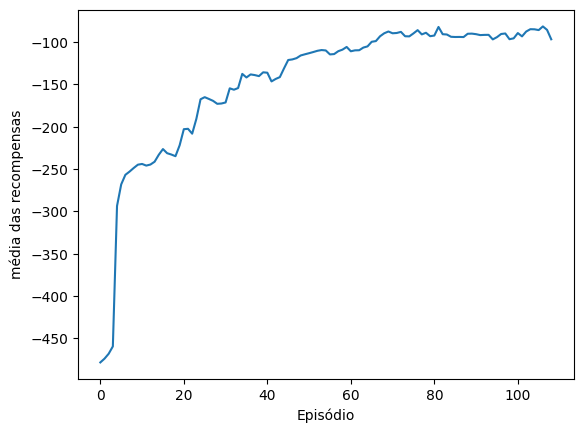


Tempo de treinamento total: 194.53 s (3.24 min)


In [23]:
tempo_inicial = time.time()

# São necessários cerca de 4 minutos para treinar
for ep in range(num_total_episodios):

    # Reseta o ambiente para o estado inicial e coleta seu valor
    cooler.reset() # reinicializa o ambiente, colocando o cooler numa velocidade inicial aleatória entre 2000 e 4500 rpm
    estado_ant = cooler.estado_inicial.reshape((-1,))
    soma_recompensas_do_episodio = 0

    while True: # loop interno: simula a passagem do tempo t

        estado_anterior_tf = tf.expand_dims(tf.convert_to_tensor(estado_ant), 0) # converte para tensorflow

        acao       = politica(estado_anterior_tf, ou_noise)
        cooler.step(acao) # pratica a ação
        estado     = cooler.estado_atual.reshape((-1,)) # próximo estado
        recompensa = cooler.recompensa # Recebe estado e recompensa do ambiente
        done       = cooler.flag_estado_terminal # flag que identifica se trata-se de um estado terminal

        buffer.armazenar_tupla((estado_ant, acao, recompensa, estado))
        soma_recompensas_do_episodio += recompensa

        buffer.agente_aprende()
        atualizacao_suave(modelo_ator_alvo.variables, modelo_ator.variables, tau)
        atualizacao_suave(modelo_critico_alvo.variables, modelo_critico.variables, tau)

        # caso a gente esteja num estado terminal, sairemos do presente episódio
        if done:
            break

        estado_ant = estado

    recompensas_hist.append(soma_recompensas_do_episodio)


    if ep>40: # calcula a média dos últimos 40 episódios (caso já tenham se passado pelo menos 40 episódios)
        recompensa_media = np.mean(recompensas_hist[-40:])
        print("Episódio * {} * Recompensa Média é ==> {}".format(ep, recompensa_media))
        recompensa_media_hist.append(recompensa_media)

# Plota gráfico de episódios versus média das recompensas
plt.plot(recompensa_media_hist)
plt.xlabel("Episódio")
plt.ylabel("média das recompensas")
plt.show()

tempo_total = time.time() - tempo_inicial

print(f"\nTempo de treinamento total: {tempo_total:.2f} s ({(tempo_total/60):.2f} min)")

<ipython-input-78-6d31320eb6b3>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  acoes_todas[t] = acao
<ipython-input-78-6d31320eb6b3>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rpm_todos[t]   = cooler.rpm_atual
<ipython-input-78-6d31320eb6b3>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ref_todas[t]   = cooler.rpm_ref_atual


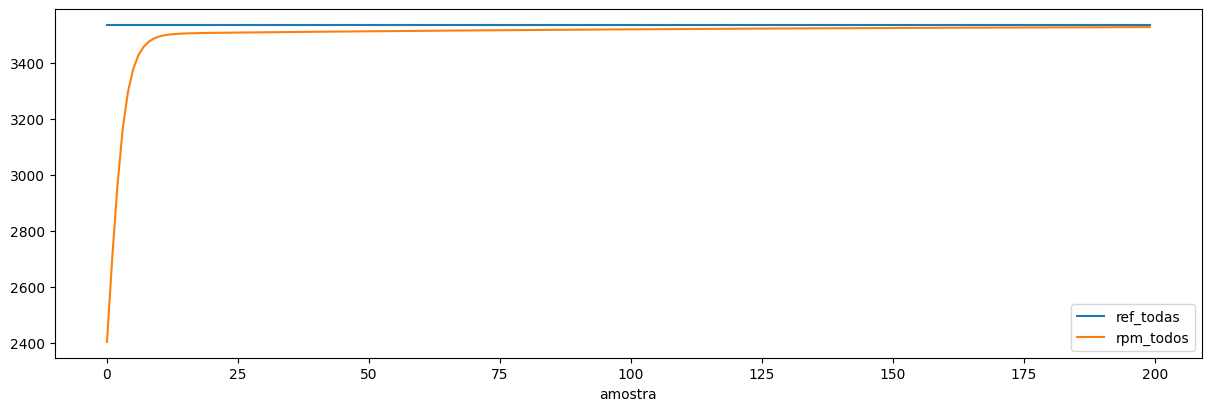

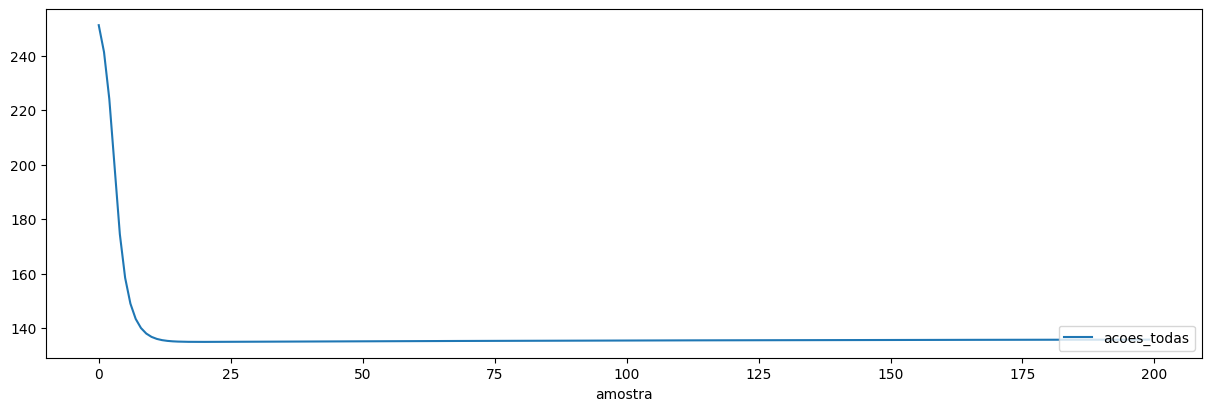

In [78]:
## Testando o Controlador obtido

cooler.reset() # reinicializa o ambiente, colocando o cooler numa velocidade inicial aleatória entre 2000 e 4500 rpm
estado_atual = cooler.estado_inicial
estado_atual = np.array([estado_atual]).reshape((1,-1))

acoes_todas    = np.zeros(200)
rpm_todos      = np.zeros(200)
ref_todas      = np.zeros(200)
num_amostras   = acoes_todas.shape[0]

for t in range(num_amostras):
    acao = modelo_ator(estado_atual).numpy()[0] # define a ação a ser praticada com base no ator
    cooler.step(acao) # pratica a ação
    estado_atual   = cooler.estado_atual.reshape((1,-1)) # atualiza o estado atual
    acoes_todas[t] = acao
    rpm_todos[t]   = cooler.rpm_atual
    ref_todas[t]   = cooler.rpm_ref_atual

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(500*ref_todas+3500, label='ref_todas')
ax.plot(500*rpm_todos+3500, label='rpm_todos')
ax.legend(loc='lower right')
ax.set_xlabel('amostra')
plt.show()

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot((acoes_todas+1)*(255-55)/2 + 55, label='acoes_todas')
ax.legend(loc='lower right')
ax.set_xlabel('amostra')
plt.show()


In [79]:
print("Parâmetros do ator treinado (controlador): ", modelo_ator.get_weights())

Parâmetros do ator treinado (controlador):  [array([[ 0.25152436],
       [-0.32354373],
       [ 1.0470132 ],
       [ 0.0077944 ]], dtype=float32), array([-0.34841335], dtype=float32)]


In [85]:
# portanto, sabendo que o estado é [rpm_atual, rpm_dot, erro], o controlador calcula a ação com base nesse estado
# da seguinte forma:
rpm_atual      = cooler.rpm_atual
rpm_dot_atual  = cooler.rpm_dot_atual
erro_atual     = cooler.erro_atual
int_erro_atual = cooler.int_erro_atual

acao = np.tanh(rpm_atual*0.25152436 + rpm_dot_atual*-0.32354373 + erro_atual*1.0470132 + int_erro_atual*0.0077944 - 0.34841335)
acao = 100*acao+155
print(acao)

[135.75356066]


In [86]:
# Ao implementarmos o controlador no arduino, temos que lembrar dos aspectos relacionados às normalizações adotadas.

# o arduino receberá as informações tal como está abaixo.
rpm_atual = 500*cooler.rpm_atual+3500
rpm_ref   = 500*cooler.rpm_ref_atual+3500
print("rpm_ref: ", rpm_ref)
print("rpm atual: ", rpm_atual)

# precisaremos então converter esses dois valores levando em conta a normalização que foi usada no aprendizado por reforço:
rpm_atual_norm = (rpm_atual-3500)/500
rpm_ref_norm   = (rpm_ref-3500)/500
print("rpm_ref após normalização: ", rpm_ref_norm)
print("rpm atual após normalização: ", rpm_atual_norm)

# a partir dessas normalizações, teremos também acesso às variáveis abaixo:
erro_norm     = rpm_ref_norm - rpm_atual_norm
rpm_dot_norm  = cooler.rpm_dot_atual # ao invés disso, no arduino faremos rpm_dot_norm  = rpm_atual_norm - rpm_ant_norm;
int_erro_norm = cooler.int_erro_atual # ao invés disso, no arduino faremos int_erro_norm = int_erro_norm + erro_norm;

acao = np.tanh(rpm_atual_norm*0.25152436 + rpm_dot_norm*-0.32354373 + erro_norm*1.0470132 + int_erro_norm*0.0077944 - 0.34841335)
acao = 100.0*acao+155.0    # é equivalente a >>> acao = (acao+1)*(255-55)/2 + 55
print("valor de pwm que será praticado no instante atual: ", acao)

rpm_ref:  [3534.7551961]
rpm atual:  [3527.859]
rpm_ref após normalização:  [0.06951039]
rpm atual após normalização:  [0.05571777]
valor de pwm que será praticado no instante atual:  [135.75355551]


In [28]:
## Salvando os pesos das redes treinadas.
#modelo_ator.save_weights("cooler_ator.h5")
#modelo_critico.save_weights("cooler_critico.h5")
#
#modelo_ator_alvo.save_weights("cooler_ator_alvo.h5")
#modelo_critico_alvo.save_weights("cooler_critico_alvo.h5")

## Conclusões

Nessa atividade você treinou uma rede neural (ator) capaz de controlar o cooler. O próximo passo consiste em embarcar esse controlador no arduino uno.

## Referências

Caso você queira aprender mais sobre Aprendizado por Reforço (especialmente a vertende usada nesse script, chamada de Aprendizado Q Profundo), veja os seguintes papers:

* [Human-level Control Through Deep Reinforcement Learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)


* [Continuous Control with Deep Reinforcement Learning](https://arxiv.org/pdf/1509.02971.pdf)


* [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)